In [ ]:
#  Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cell 2: Verify dataset structure
import os

# Define project paths
PROJECT_ROOT = '/content/drive/MyDrive/CircuitGuard_Project'
DATASET_PATH = f'{PROJECT_ROOT}/dataset/PCB_DATASET'

# Check if dataset exists
if os.path.exists(DATASET_PATH):
    print("✅ Dataset found!")
    print("\n📂 Dataset structure:")

    # List all folders in dataset
    for item in os.listdir(DATASET_PATH):
        item_path = os.path.join(DATASET_PATH, item)
        if os.path.isdir(item_path):
            # Count files in each folder
            if item == 'images' or item == 'Annotations' or item == 'rotation':
                subfolders = os.listdir(item_path)
                print(f"\n  📁 {item}/")
                for subfolder in subfolders:
                    subfolder_path = os.path.join(item_path, subfolder)
                    if os.path.isdir(subfolder_path):
                        file_count = len(os.listdir(subfolder_path))
                        print(f"    └── {subfolder}/ ({file_count} files)")
            elif item == 'PCB_USED':
                file_count = len(os.listdir(item_path))
                print(f"\n  📁 {item}/ ({file_count} files)")
else:
    print("❌ Dataset not found!")
    print(f"Expected path: {DATASET_PATH}")
    print("\n⚠️ Please upload your dataset to Google Drive first!")

✅ Dataset found!

📂 Dataset structure:

  📁 images/
    └── Mouse_bite/ (115 files)
    └── Missing_hole/ (115 files)
    └── Short/ (116 files)
    └── Spur/ (115 files)
    └── Open_circuit/ (116 files)
    └── Spurious_copper/ (116 files)

  📁 Annotations/
    └── Missing_hole/ (115 files)
    └── Open_circuit/ (116 files)
    └── Mouse_bite/ (115 files)
    └── Short/ (116 files)
    └── Spurious_copper/ (116 files)
    └── Spur/ (115 files)

  📁 rotation/
    └── Missing_hole_rotation/ (115 files)
    └── Open_circuit_rotation/ (116 files)
    └── Short_rotation/ (116 files)
    └── Mouse_bite_rotation/ (115 files)
    └── Spurious_copper_rotation/ (116 files)
    └── Spur_rotation/ (115 files)

  📁 PCB_USED/ (10 files)


In [ ]:
# Cell 3: Install required libraries
!pip install -q opencv-python-headless
!pip install -q albumentations
!pip install -q efficientnet-pytorch

print("✅ All libraries installed successfully!")

  Preparing metadata (setup.py) ... done
✅ All libraries installed successfully!


In [ ]:

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import xml.etree.ElementTree as ET
from collections import defaultdict
import json
from tqdm import tqdm
import shutil

In [ ]:
# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

In [ ]:
# Define Project Paths

print("="*70)
print("STEP 1: Setting Up Project Paths")
print("="*70)

# Main project directory
PROJECT_ROOT = '/content/drive/MyDrive/CircuitGuard_Project'
DATASET_PATH = f'{PROJECT_ROOT}/dataset/PCB_DATASET'

STEP 1: Setting Up Project Paths


In [ ]:
# Dataset subdirectories
TEMPLATES_PATH = f'{DATASET_PATH}/PCB_USED'
IMAGES_PATH = f'{DATASET_PATH}/images'
ANNOTATIONS_PATH = f'{DATASET_PATH}/Annotations'
ROTATION_PATH = f'{DATASET_PATH}/rotation'

# Output directories
OUTPUT_ROOT = f'{PROJECT_ROOT}/outputs'
PREPROCESSED_PATH = f'{OUTPUT_ROOT}/preprocessed'
VISUALIZATIONS_PATH = f'{OUTPUT_ROOT}/visualizations'
DEFECT_MASKS_PATH = f'{OUTPUT_ROOT}/defect_masks'
ROI_CROPS_PATH = f'{OUTPUT_ROOT}/roi_crops'


In [ ]:
# Create output directories
os.makedirs(PREPROCESSED_PATH, exist_ok=True)
os.makedirs(VISUALIZATIONS_PATH, exist_ok=True)
os.makedirs(DEFECT_MASKS_PATH, exist_ok=True)
os.makedirs(ROI_CROPS_PATH, exist_ok=True)

print(f"\n✅ Project Root: {PROJECT_ROOT}")
print(f"✅ Dataset Path: {DATASET_PATH}")
print(f"✅ Output Path: {OUTPUT_ROOT}")


✅ Project Root: /content/drive/MyDrive/CircuitGuard_Project
✅ Dataset Path: /content/drive/MyDrive/CircuitGuard_Project/dataset/PCB_DATASET
✅ Output Path: /content/drive/MyDrive/CircuitGuard_Project/outputs


In [ ]:
# Auto-Detect Defect Category Folder Names
print("\n" + "="*70)
print("STEP 2: Auto-Detecting Defect Categories")
print("="*70)

def get_actual_folder_names(base_path, templates):
    """Find actual folder names matching templates (case-insensitive)"""
    if not os.path.exists(base_path):
        return []

    actual_folders = os.listdir(base_path)
    matched = {}

    for template in templates:
        for folder in actual_folders:
            if folder.lower() == template.lower().replace('_', '').replace(' ', ''):
                matched[template] = folder
                break
            elif folder.lower().replace('_', '') == template.lower().replace('_', ''):
                matched[template] = folder
                break

    return matched

# Expected category names (standardized)
CATEGORY_TEMPLATES = [
    'missing_hole',
    'mouse_bite',
    'open_circuit',
    'short',
    'spur',
    'spurious_copper'
]

# Get actual folder names from dataset
CATEGORY_MAPPING = get_actual_folder_names(IMAGES_PATH, CATEGORY_TEMPLATES)

print(f"\n📂 Detected Categories (Template → Actual):")
for template, actual in CATEGORY_MAPPING.items():
    print(f"  {template:20s} → {actual}")

if not CATEGORY_MAPPING:
    print("\n❌ No defect categories found!")
    raise FileNotFoundError("Cannot find defect category folders!")





STEP 2: Auto-Detecting Defect Categories

📂 Detected Categories (Template → Actual):
  missing_hole         → Missing_hole
  mouse_bite           → Mouse_bite
  open_circuit         → Open_circuit
  short                → Short
  spur                 → Spur
  spurious_copper      → Spurious_copper


In [ ]:
# Analyze Dataset Statistics
print("\n" + "="*70)
print("STEP 3: Analyzing Dataset Statistics")
print("="*70)

def count_files_in_directory(directory, extensions=('.jpg', '.jpeg', '.png')):
    """Count files with specific extensions in a directory"""
    if not os.path.exists(directory):
        return 0
    return len([f for f in os.listdir(directory)
                if f.lower().endswith(extensions)])

# Count template images
template_count = count_files_in_directory(TEMPLATES_PATH)
print(f"\n📁 Template PCBs (PCB_USED): {template_count} images")

# Count defect images by category
print(f"\n📁 Defect Images by Category:")
print("-" * 70)

defect_stats = {}
for template_name, actual_folder in CATEGORY_MAPPING.items():
    img_path = os.path.join(IMAGES_PATH, actual_folder)
    ann_path = os.path.join(ANNOTATIONS_PATH, actual_folder)
    rot_path = os.path.join(ROTATION_PATH, f"{actual_folder}_rotation")

    img_count = count_files_in_directory(img_path)
    ann_count = count_files_in_directory(ann_path, ('.xml',))
    rot_count = count_files_in_directory(rot_path)

    defect_stats[template_name] = {
        'actual_folder': actual_folder,
        'images': img_count,
        'annotations': ann_count,
        'rotations': rot_count
    }

    print(f"  {template_name:20s} | Images: {img_count:3d} | Annotations: {ann_count:3d} | Rotations: {rot_count:3d}")

# Calculate totals
total_images = sum(stats['images'] for stats in defect_stats.values())
total_annotations = sum(stats['annotations'] for stats in defect_stats.values())
total_rotations = sum(stats['rotations'] for stats in defect_stats.values())

print("-" * 70)
print(f"  {'TOTAL':20s} | Images: {total_images:3d} | Annotations: {total_annotations:3d} | Rotations: {total_rotations:3d}")




STEP 3: Analyzing Dataset Statistics

📁 Template PCBs (PCB_USED): 10 images

📁 Defect Images by Category:
----------------------------------------------------------------------
  missing_hole         | Images: 115 | Annotations: 115 | Rotations: 115
  mouse_bite           | Images: 115 | Annotations: 115 | Rotations: 115
  open_circuit         | Images: 116 | Annotations: 116 | Rotations: 116
  short                | Images: 116 | Annotations: 116 | Rotations: 116
  spur                 | Images: 115 | Annotations: 115 | Rotations: 115
  spurious_copper      | Images: 116 | Annotations: 116 | Rotations: 116
----------------------------------------------------------------------
  TOTAL                | Images: 693 | Annotations: 693 | Rotations: 693


In [ ]:
#  Parse XML Annotations
print("\n" + "="*70)
print("STEP 4: Parsing XML Annotations")
print("="*70)

def parse_xml_annotation(xml_file):
    """Parse Pascal VOC XML annotation file"""
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()

        annotation = {
            'filename': root.find('filename').text,
            'width': int(root.find('size/width').text),
            'height': int(root.find('size/height').text),
            'objects': []
        }

        for obj in root.findall('object'):
            bbox = obj.find('bndbox')
            obj_data = {
                'name': obj.find('name').text,
                'xmin': int(bbox.find('xmin').text),
                'ymin': int(bbox.find('ymin').text),
                'xmax': int(bbox.find('xmax').text),
                'ymax': int(bbox.find('ymax').text)
            }
            annotation['objects'].append(obj_data)

        return annotation
    except Exception as e:
        return None

# Parse all annotations
all_annotations = {}

for template_name, actual_folder in CATEGORY_MAPPING.items():
    ann_path = os.path.join(ANNOTATIONS_PATH, actual_folder)
    if not os.path.exists(ann_path):
        print(f"⚠️ Annotation folder not found: {actual_folder}")
        continue

    category_annotations = []
    xml_files = [f for f in os.listdir(ann_path) if f.endswith('.xml')]

    for xml_file in xml_files:
        xml_path = os.path.join(ann_path, xml_file)
        annotation = parse_xml_annotation(xml_path)
        if annotation:
            category_annotations.append(annotation)

    all_annotations[template_name] = category_annotations
    print(f"✅ Parsed {len(category_annotations)} annotations for {template_name}")


STEP 4: Parsing XML Annotations
✅ Parsed 115 annotations for missing_hole
✅ Parsed 115 annotations for mouse_bite
✅ Parsed 116 annotations for open_circuit
✅ Parsed 116 annotations for short
✅ Parsed 115 annotations for spur
✅ Parsed 116 annotations for spurious_copper



STEP 5: Creating Visualizations

✅ Saved visualization: /content/drive/MyDrive/CircuitGuard_Project/outputs/visualizations/dataset_statistics.png


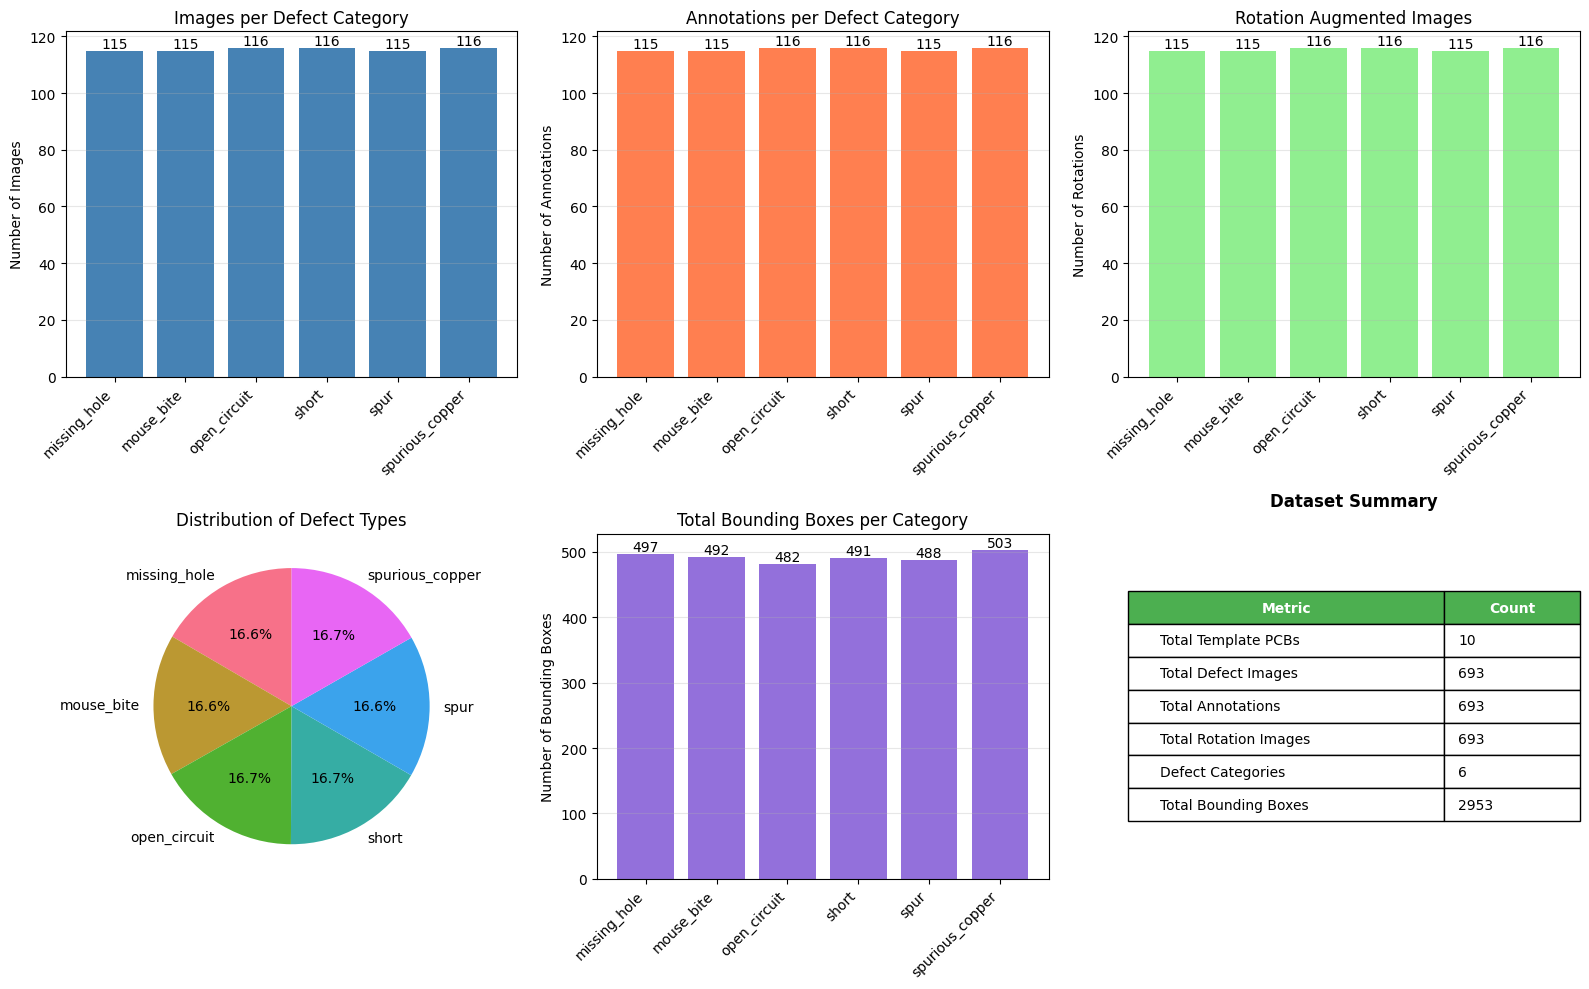

In [ ]:
# Visualize Dataset Statistics
print("\n" + "="*70)
print("STEP 5: Creating Visualizations")
print("="*70)

# Prepare data for visualization
categories = list(defect_stats.keys())
image_counts = [defect_stats[cat]['images'] for cat in categories]
ann_counts = [defect_stats[cat]['annotations'] for cat in categories]
rot_counts = [defect_stats[cat]['rotations'] for cat in categories]
bbox_counts = [sum(len(ann['objects']) for ann in all_annotations.get(cat, [])) for cat in categories]

# Create figure
fig = plt.figure(figsize=(16, 10))

# 1. Images per category
ax1 = plt.subplot(2, 3, 1)
bars = ax1.bar(range(len(categories)), image_counts, color='steelblue')
ax1.set_xticks(range(len(categories)))
ax1.set_xticklabels(categories, rotation=45, ha='right')
ax1.set_ylabel('Number of Images')
ax1.set_title('Images per Defect Category')
ax1.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=10)

# 2. Annotations per category
ax2 = plt.subplot(2, 3, 2)
bars = ax2.bar(range(len(categories)), ann_counts, color='coral')
ax2.set_xticks(range(len(categories)))
ax2.set_xticklabels(categories, rotation=45, ha='right')
ax2.set_ylabel('Number of Annotations')
ax2.set_title('Annotations per Defect Category')
ax2.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=10)

# 3. Rotation augmentation
ax3 = plt.subplot(2, 3, 3)
bars = ax3.bar(range(len(categories)), rot_counts, color='lightgreen')
ax3.set_xticks(range(len(categories)))
ax3.set_xticklabels(categories, rotation=45, ha='right')
ax3.set_ylabel('Number of Rotations')
ax3.set_title('Rotation Augmented Images')
ax3.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=10)

# 4. Distribution pie chart
ax4 = plt.subplot(2, 3, 4)
ax4.pie(image_counts, labels=categories, autopct='%1.1f%%', startangle=90)
ax4.set_title('Distribution of Defect Types')

# 5. Bounding box statistics
ax5 = plt.subplot(2, 3, 5)
bars = ax5.bar(range(len(categories)), bbox_counts, color='mediumpurple')
ax5.set_xticks(range(len(categories)))
ax5.set_xticklabels(categories, rotation=45, ha='right')
ax5.set_ylabel('Number of Bounding Boxes')
ax5.set_title('Total Bounding Boxes per Category')
ax5.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=10)

# 6. Dataset summary table
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')

summary_data = [
    ['Total Template PCBs', template_count],
    ['Total Defect Images', total_images],
    ['Total Annotations', total_annotations],
    ['Total Rotation Images', total_rotations],
    ['Defect Categories', len(categories)],
    ['Total Bounding Boxes', sum(bbox_counts)]
]

table = ax6.table(cellText=summary_data, colLabels=['Metric', 'Count'],
                  cellLoc='left', loc='center', colWidths=[0.7, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

for i in range(2):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

ax6.set_title('Dataset Summary', fontsize=12, weight='bold', pad=20)

plt.tight_layout()
plt.savefig(f'{VISUALIZATIONS_PATH}/dataset_statistics.png', dpi=300, bbox_inches='tight')
print(f"\n✅ Saved visualization: {VISUALIZATIONS_PATH}/dataset_statistics.png")
plt.show()




STEP 6: Creating Sample Image Visualizations
✅ Saved: /content/drive/MyDrive/CircuitGuard_Project/outputs/visualizations/sample_images_with_bboxes.png


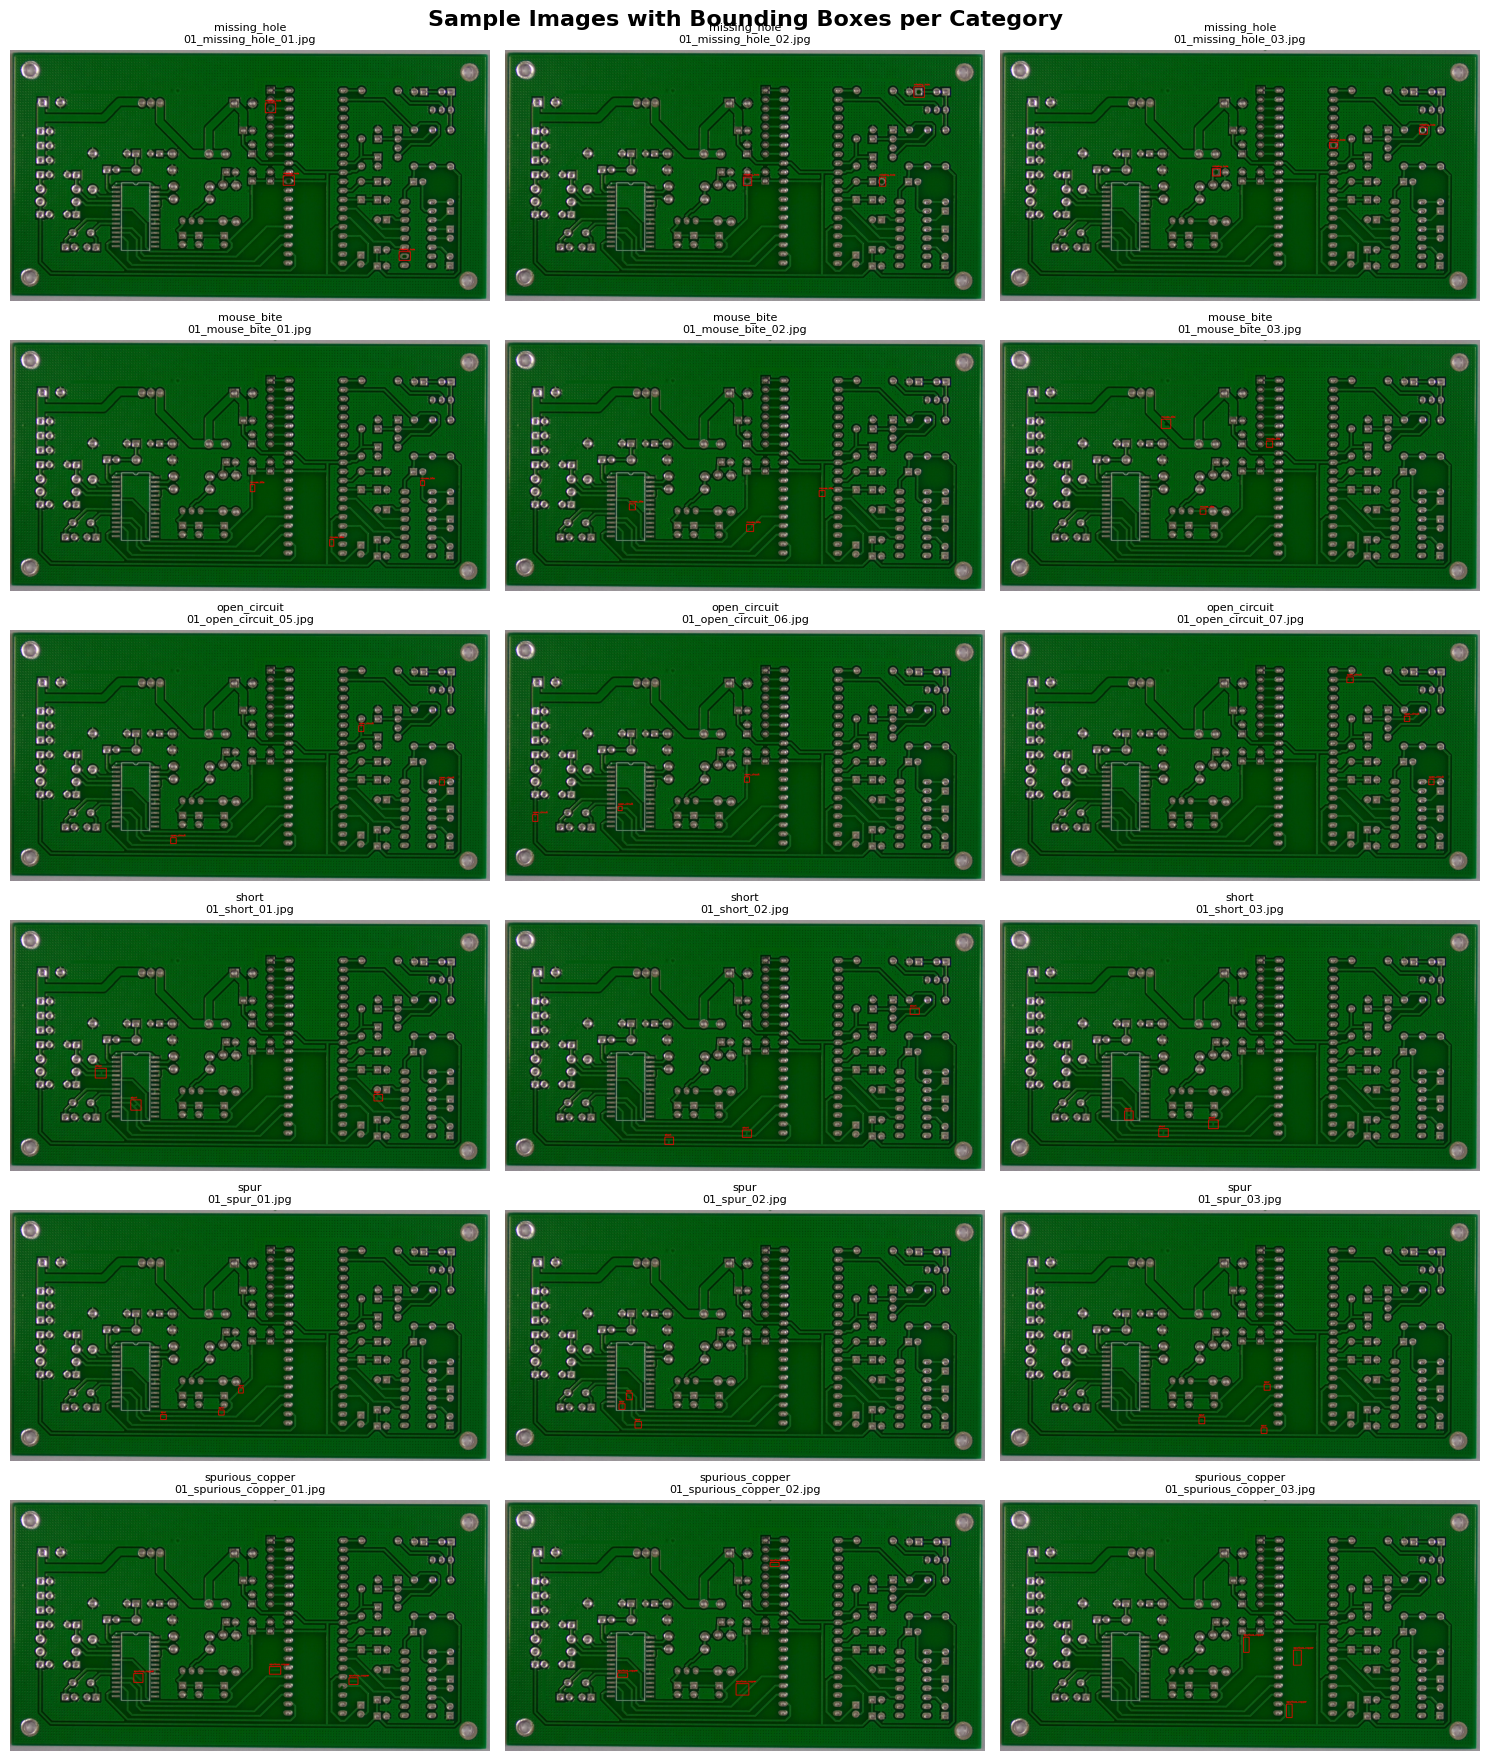

In [ ]:
# Sample Visualizations with Bounding Boxes

print("\n" + "="*70)
print("STEP 6: Creating Sample Image Visualizations")
print("="*70)

def visualize_samples(num_samples=3):
    """Visualize sample images from each category with bounding boxes"""

    fig, axes = plt.subplots(len(categories), num_samples, figsize=(15, 18))
    fig.suptitle('Sample Images with Bounding Boxes per Category', fontsize=16, weight='bold')

    for i, (template_name, actual_folder) in enumerate(CATEGORY_MAPPING.items()):
        img_path = os.path.join(IMAGES_PATH, actual_folder)
        ann_path = os.path.join(ANNOTATIONS_PATH, actual_folder)

        if not os.path.exists(img_path):
            continue

        # Get sample images
        image_files = [f for f in os.listdir(img_path)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:num_samples]

        for j, img_file in enumerate(image_files):
            # Load image
            img_full_path = os.path.join(img_path, img_file)
            img = cv2.imread(img_full_path)
            if img is None:
                continue
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Load annotation
            base_name = os.path.splitext(img_file)[0]
            xml_file = base_name + '.xml'
            xml_path = os.path.join(ann_path, xml_file)

            # Draw bounding boxes if annotation exists
            if os.path.exists(xml_path):
                annotation = parse_xml_annotation(xml_path)
                if annotation and annotation['objects']:
                    for obj in annotation['objects']:
                        cv2.rectangle(img_rgb,
                                    (obj['xmin'], obj['ymin']),
                                    (obj['xmax'], obj['ymax']),
                                    (255, 0, 0), 3)
                        # Add label
                        cv2.putText(img_rgb, obj['name'],
                                  (obj['xmin'], obj['ymin']-10),
                                  cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

            # Display
            axes[i, j].imshow(img_rgb)
            axes[i, j].set_title(f"{template_name}\n{img_file}", fontsize=8)
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.savefig(f'{VISUALIZATIONS_PATH}/sample_images_with_bboxes.png', dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {VISUALIZATIONS_PATH}/sample_images_with_bboxes.png")
    plt.show()

visualize_samples(num_samples=3)




In [ ]:
#  Extract PCB IDs
print("\n" + "="*70)
print("STEP 7: Extracting PCB IDs")
print("="*70)

def extract_pcb_id(filename):
    """Extract PCB ID from filename"""
    parts = filename.split('_')
    if len(parts) > 0 and parts[0].isdigit():
        return parts[0]
    name_without_ext = os.path.splitext(filename)[0]
    if name_without_ext.isdigit():
        return name_without_ext
    return None

# Get unique PCB IDs from templates
pcb_ids = set()
if os.path.exists(TEMPLATES_PATH):
    template_files = os.listdir(TEMPLATES_PATH)
    for template_file in template_files:
        if template_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            pcb_id = extract_pcb_id(template_file)
            if pcb_id:
                pcb_ids.add(pcb_id)

pcb_ids = sorted(list(pcb_ids))
print(f"\n✅ Found {len(pcb_ids)} unique PCB designs: {pcb_ids}")


STEP 7: Extracting PCB IDs

✅ Found 10 unique PCB designs: ['01', '04', '05', '06', '07', '08', '09', '10', '11', '12']


In [ ]:
#Create Template-Defect Mapping
print("\n" + "="*70)
print("STEP 8: Creating Template-Defect Image Mapping")
print("="*70)

template_defect_mapping = defaultdict(lambda: defaultdict(list))

for template_name, actual_folder in CATEGORY_MAPPING.items():
    img_path = os.path.join(IMAGES_PATH, actual_folder)
    if not os.path.exists(img_path):
        continue

    defect_files = [f for f in os.listdir(img_path)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    for defect_file in defect_files:
        pcb_id = extract_pcb_id(defect_file)
        if pcb_id:
            template_defect_mapping[pcb_id][template_name].append(defect_file)

print("\nTemplate-Defect Mapping Summary:")
print("-" * 70)
for pcb_id in sorted(template_defect_mapping.keys()):
    total_defects = sum(len(files) for files in template_defect_mapping[pcb_id].values())
    print(f"PCB ID {pcb_id}: {total_defects} defect images across {len(template_defect_mapping[pcb_id])} categories")


STEP 8: Creating Template-Defect Image Mapping

Template-Defect Mapping Summary:
----------------------------------------------------------------------
PCB ID 01: 120 defect images across 6 categories
PCB ID 04: 120 defect images across 6 categories
PCB ID 05: 60 defect images across 6 categories
PCB ID 06: 61 defect images across 6 categories
PCB ID 07: 60 defect images across 6 categories
PCB ID 08: 60 defect images across 6 categories
PCB ID 09: 60 defect images across 6 categories
PCB ID 10: 32 defect images across 6 categories
PCB ID 11: 60 defect images across 6 categories
PCB ID 12: 60 defect images across 6 categories


In [ ]:
# save Dataset Metadata
print("\n" + "="*70)
print("STEP 9: Saving Dataset Metadata")
print("="*70)

metadata = {
    'dataset_path': DATASET_PATH,
    'total_template_images': template_count,
    'total_defect_images': total_images,
    'total_annotations': total_annotations,
    'total_rotation_images': total_rotations,
    'category_mapping': CATEGORY_MAPPING,
    'pcb_ids': pcb_ids,
    'defect_statistics': defect_stats,
    'template_defect_mapping': {k: dict(v) for k, v in template_defect_mapping.items()}
}

metadata_path = f'{PROJECT_ROOT}/dataset_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"✅ Metadata saved to: {metadata_path}")



STEP 9: Saving Dataset Metadata
✅ Metadata saved to: /content/drive/MyDrive/CircuitGuard_Project/dataset_metadata.json


In [ ]:
# Summary
print("\n" + "="*70)
print("MODULE 1 COMPLETED SUCCESSFULLY!")
print("="*70)
print("\n📊 Summary:")
print(f"  ✅ Dataset verified and loaded")
print(f"  ✅ Found {len(pcb_ids)} unique PCB designs: {pcb_ids}")
print(f"  ✅ Total defect images: {total_images}")
print(f"  ✅ Total annotations: {total_annotations}")
print(f"  ✅ Total rotation images: {total_rotations}")
print(f"  ✅ Generated visualizations")
print(f"  ✅ Created template-defect mappings")
print(f"  ✅ Saved metadata to JSON")


MODULE 1 COMPLETED SUCCESSFULLY!

📊 Summary:
  ✅ Dataset verified and loaded
  ✅ Found 10 unique PCB designs: ['01', '04', '05', '06', '07', '08', '09', '10', '11', '12']
  ✅ Total defect images: 693
  ✅ Total annotations: 693
  ✅ Total rotation images: 693
  ✅ Generated visualizations
  ✅ Created template-defect mappings
  ✅ Saved metadata to JSON
